In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
from importlib import reload
import warnings
import healpy as hp
import collections
from collections import namedtuple

sys.path.insert(0,'../../scripts/tools_for_VAE/')
from tools_for_VAE import cutout_img_dc2
from tools_for_VAE import plot

import galsim

%matplotlib inline
%config InlineBackend.figure_format='retina'

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.visualization import ZScaleInterval
from astropy.table import Table

In [3]:
import lsst.afw.display as afwDisplay
import lsst.afw.display.rgb as rgb

import FoFCatalogMatching
import GCRCatalogs
GCRCatalogs.set_root_dir_by_site('in2p3')
import fitsio

import lsst.afw.geom as afw_geom
import lsst.afw.table as afw_table
import lsst.daf.persistence as dp
import lsst.daf.persistence as dafPersist
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.geom

## Import test data

In [4]:
data_dir = '/pbs/home/b/barcelin/sps_link/data/dc2_test'
test_data = pd.read_csv(data_dir+'/test_24.5_v2/img_data_2.csv')
psf_img = np.load(data_dir+'/test_24.5_v2/psf_sample_2.npy', mmap_mode = 'c')
gal_img = np.load(data_dir+'/test_24.5_v2/img_sample_2.npy', mmap_mode = 'c')

In [5]:
test_data.info

<bound method DataFrame.info of               id        e1        e2   shear_1   shear_2  redshift  \
0     6000542719  0.107939 -0.378144  0.003401  0.001616  0.555395   
1     7002508926  0.030137  0.078186 -0.000434 -0.007706  1.035572   
2     7003076680 -0.274697  0.108764  0.011749  0.005150  1.103071   
3     7001184867 -0.187118  0.302167 -0.000108 -0.003375  0.760792   
4     6001754782 -0.005709  0.004559  0.000341 -0.009107  0.915118   
...          ...       ...       ...       ...       ...       ...   
9995  6001717626  0.002835  0.018597 -0.004006 -0.010442  0.877400   
9996  7000242038 -0.205442 -0.185545  0.000925 -0.006511  0.423894   
9997  6003355673 -0.047292 -0.073065 -0.004399 -0.008524  1.186279   
9998  7001019321  0.035125  0.022583  0.005510 -0.004774  0.708222   
9999  7004778616 -0.002488 -0.019835  0.000217 -0.001776  1.427254   

      redshift_true   blendedness       snr_r  convergence  e1_hsm_regauss  \
0          0.555024  0.000000e+00  143.526553    

## Retrieve info from catalogs

In [6]:
repo = '/sps/lssttest/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-grizy'
butler = dafPersist.Butler(repo)

# Read in the galaxy catalog data.
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')
    
    
# Read in the galaxy catalog data.
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    gc_obs = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_wfd')

In [7]:
gc_obs.list_all_quantities(include_native=True)

['modelfit_CModel_initial_ellipse_xy',
 'y_undeblended_ext_convolved_ConvolvedFlux_3_kron_instFlux',
 'y_base_PsfFlux_instFluxErr',
 'u_slot_PsfShape_xx',
 'g_undeblended_ext_convolved_ConvolvedFlux_0_6_0_apCorr',
 'modelfit_CModel_exp_flag_trSmall',
 'u_undeblended_base_CircularApertureFlux_25_0_instFlux',
 'g_undeblended_base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated',
 'u_ext_convolved_ConvolvedFlux_0_3_3_apCorr',
 'y_undeblended_ext_convolved_ConvolvedFlux_0_deconv',
 'u_base_CircularApertureFlux_35_0_flag_apertureTruncated',
 'g_undeblended_ext_convolved_ConvolvedFlux_1_flag_badCentroid',
 'g_base_PixelFlags_flag_clipped',
 'z_undeblended_ext_convolved_ConvolvedFlux_0_deconv',
 'i_undeblended_ext_convolved_ConvolvedFlux_1_4_5_apCorr',
 'i_undeblended_base_PsfFlux_instFlux',
 'u_base_PsfFlux_flag_edge',
 'z_base_PixelFlags_flag_inexact_psfCenter',
 'i_ext_convolved_ConvolvedFlux_0_4_5_apCorrErr',
 'i_base_CircularApertureFlux_12_0_flag_apertureTruncated',
 'i_undeblended_ba

In [8]:
gc.list_all_quantities(include_native=True)

['mag_i_lsst_no_host_extinction',
 'SDSS_filters/diskLuminositiesStellar:SDSS_g:rest',
 'totalMassStellar',
 'SEDs/diskLuminositiesStellar:SED_6954_431:rest:dustAtlas',
 'LSST_filters/totalLuminositiesStellar:LSST_i:observed:dustAtlas',
 'Mag_true_r_sdss_z0_no_host_extinction',
 'sed_3184_197',
 'LSST_filters/magnitude:LSST_z:rest',
 'SEDs/diskLuminositiesStellar:SED_4565_283:rest:dustAtlas',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_g:observed',
 'SDSS_filters/diskLuminositiesStellar:SDSS_z:observed',
 'sed_4299_266',
 'SEDs/diskLuminositiesStellar:SED_2998_186:rest',
 'hostHaloMass',
 'SEDs/diskLuminositiesStellar:SED_2407_591:rest',
 'sed_2407_591',
 'morphology/diskMajorAxisArcsec',
 'sed_2998_186',
 'SEDs/diskLuminositiesStellar:SED_7385_458:rest:dustAtlas',
 'LSST_filters/diskLuminositiesStellar:LSST_i:observed:dustAtlas',
 'sed_7843_486_disk',
 'baseDC2/_obs_sm_orig_um_snap',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_z:rest',
 'baseDC2/vx',
 'sed_1000_246_disk',
 'LS

In [9]:
print(', '.join(sorted(gc.list_all_quantities(include_native=True))))

A_v, A_v_bulge, A_v_disk, LSST_filters/diskLuminositiesStellar:LSST_g:observed, LSST_filters/diskLuminositiesStellar:LSST_g:observed:dustAtlas, LSST_filters/diskLuminositiesStellar:LSST_g:rest, LSST_filters/diskLuminositiesStellar:LSST_g:rest:dustAtlas, LSST_filters/diskLuminositiesStellar:LSST_i:observed, LSST_filters/diskLuminositiesStellar:LSST_i:observed:dustAtlas, LSST_filters/diskLuminositiesStellar:LSST_i:rest, LSST_filters/diskLuminositiesStellar:LSST_i:rest:dustAtlas, LSST_filters/diskLuminositiesStellar:LSST_r:observed, LSST_filters/diskLuminositiesStellar:LSST_r:observed:dustAtlas, LSST_filters/diskLuminositiesStellar:LSST_r:rest, LSST_filters/diskLuminositiesStellar:LSST_r:rest:dustAtlas, LSST_filters/diskLuminositiesStellar:LSST_u:observed, LSST_filters/diskLuminositiesStellar:LSST_u:observed:dustAtlas, LSST_filters/diskLuminositiesStellar:LSST_u:rest, LSST_filters/diskLuminositiesStellar:LSST_u:rest:dustAtlas, LSST_filters/diskLuminositiesStellar:LSST_y:observed, LSST_fil

In [10]:
# Let's define a magnitude cut
mag_filters = [
    (np.isfinite, 'mag_r'),
    'mag_r < 24.5',
]

# Load ra and dec from object, using both of the filters we just defined.

## The test sample was generated with the tract 4029
object_data = gc_obs.get_quantities(['ra', 'dec', 'r_FLUXMAG0'],
                                        filters=(mag_filters), native_filters=['tract == 4029'])

/pbs/home/b/barcelin/pbs_throng_link/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/GCRCatalogs-1.0.1-py3.7.egg/GCRCatalogs/dc2_dm_catalog.py:44: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


In [11]:
object_data['r_FLUXMAG0']

array([6.30957344e+10, 6.30957344e+10, 6.30957344e+10, ...,
       6.30957344e+10, 6.30957344e+10, 6.30957344e+10])

Find same quantities in truth catalog

In [12]:
max_ra = np.nanmax(object_data['ra'])
min_ra = np.nanmin(object_data['ra'])
max_dec = np.nanmax(object_data['dec'])
min_dec = np.nanmin(object_data['dec'])
vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
native_filter = f'(healpix_pixel == {ipix[0]})'
for ipx in ipix:
    native_filter=native_filter+f' | (healpix_pixel == {ipx})'
pos_filters=[f'ra >= {min_ra}',f'ra <={max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

truth_mag_filters = ['mag_r < 24.5']
quantities = ['galaxy_id', 'ra', 'dec', 'ellipticity_1_bulge_true', 'bulge_to_total_ratio_i', 'sersic_bulge', 'ellipticity_2_bulge_true', 
              'size_disk_true','ellipticity_1_disk_true', 'ellipticity_2_disk_true', 'sersic_disk', 'morphology/diskHalfLightRadiusArcsec',
              'morphology/spheroidHalfLightRadiusArcsec', 'mag_true_Y_lsst', 'mag_true_i_lsst', 'mag_true_g_lsst', 'mag_true_u_lsst', 'mag_true_r_lsst',
              'mag_true_z_lsst', 'size_bulge_true', 'size_disk_true','redshift', 'redshift_true',
             'ellipticity_1_true', 'ellipticity_2_true', 'Mag_true_r_lsst_z0', 'mag_r_lsst', 'LSST_filters/totalLuminositiesStellar:LSST_i:rest',
              'LSST_filters/totalLuminositiesStellar:LSST_r:rest', 'LSST_filters/totalLuminositiesStellar:LSST_r:observed',
              'LSST_filters/totalLuminositiesStellar:LSST_r:rest:dustAtlas','LSST_filters/totalLuminositiesStellar:LSST_r:observed:dustAtlas','matchUp/luminosityFactor',
              'convergence','LSST_filters/magnitude:LSST_r:rest','sed_4848_300_disk',
              'shear_1', 'shear_2']

truth_data = gc.get_quantities(quantities, filters=truth_mag_filters+pos_filters, 
                                      native_filters=native_filter)

In [13]:
truth_data['sed_4848_300_disk']

array([2.4607154e+07, 1.1115243e+07, 3.6616624e+07, ..., 2.3203951e+01,
       2.3104641e+05, 1.5355409e+07], dtype=float32)

In [14]:
 'SEDs/totalLuminositiesStellar:SED_15143_2259:rest','SEDs/totalLuminositiesStellar:SED_3590_222:rest','SEDs/totalLuminositiesStellar:SED_5467_339:rest', 
    'SEDs/totalLuminositiesStellar:SED_1933_474:rest', 'SEDs/totalLuminositiesStellar:SED_11467_1710:rest', 'SEDs/totalLuminositiesStellar:SED_5806_360:rest',
    'SEDs/totalLuminositiesStellar:SED_2998_186:rest',

IndentationError: unexpected indent (<ipython-input-14-659acfcec55e>, line 2)

In [15]:
-2.5*np.log10(1+truth_data['redshift_true'])

array([-0.39721264, -0.39721264, -0.50120301, ..., -1.50996997,
       -1.50060012, -1.4961172 ])

In [16]:
truth_data['LSST_filters/magnitude:LSST_r:rest']

array([-20.187386, -18.65506 , -19.399801, ..., -22.717068, -22.959648,
       -21.723022], dtype=float32)

In [17]:
truth_data['matchUp/luminosityFactor']

array([1.0146948 , 0.99901116, 1.0101593 , ..., 1.006825  , 0.88432956,
       0.9766734 ], dtype=float32)

In [18]:
a = truth_data['LSST_filters/totalLuminositiesStellar:LSST_r:rest'][0]#+truth_data['LSST_filters/totalLuminositiesStellar:LSST_r:rest:dustAtlas'][0]
print(a)

118837720.0


In [19]:
-2.5*np.log10(a)

-20.187385082244873

In [20]:
def convert_flux_to_nanoJansky(flux, fluxmag0):
    """Convert the listed DM coadd-reported flux values to nanoJansky.
    Based on the given fluxmag0 value, which is AB mag = 0.
    Eventually we will get nJy from the final calibrated DRP processing.
    """
    #pylint: disable=C0103
    AB_mag_zp_wrt_Jansky = 8.90  # Definition of AB
    # 9 is from nano=10**(-9)
    #pylint: disable=C0103
    AB_mag_zp_wrt_nanoJansky = 2.5 * 9 + AB_mag_zp_wrt_Jansky

    return 10**((AB_mag_zp_wrt_nanoJansky)/2.5) * flux / fluxmag0

In [21]:
def convert_nanoJansky_to_mag(flux):
    """Convert calibrated nanoJansky flux to AB mag.
    """
    #pylint: disable=C0103
    AB_mag_zp_wrt_Jansky = 8.90  # Definition of AB
    # 9 is from nano=10**(-9)
    #pylint: disable=C0103
    AB_mag_zp_wrt_nanoJansky = 2.5 * 9 + AB_mag_zp_wrt_Jansky

    return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky

In [22]:
def convert_flux_to_mag(flux, fluxmag0):
    """Convert calibrated flux to AB mag.
    """
    flux_nJ = convert_flux_to_nanoJansky(flux, fluxmag0)
    mag_AB = convert_nanoJansky_to_mag(flux_nJ)
    return mag_AB

In [23]:
convert_flux_to_mag(a,6.30957344e+10)

6.812614221892371

In [24]:
10**(-(truth_data['mag_true_r_lsst'][0]-31.4)/2.5)

1725.239390012882

In [25]:
b = truth_data['LSST_filters/totalLuminositiesStellar:LSST_r:observed'][0]#+truth_data['LSST_filters/totalLuminositiesStellar:LSST_r:observed:dustAtlas'][0]
print(b)

96260630.0


In [26]:
-2.5*np.log10(b)

-19.95862126350403

In [27]:
truth_data['Mag_true_r_lsst_z0'][0]

-18.81882

In [28]:
truth_data['mag_true_r_lsst'][0], truth_data['mag_r_lsst'][0]

(23.307877, 23.31065512943487)

In [29]:
truth_data['mag_true_r_lsst'][0]-truth_data['mag_r_lsst'][0]

-0.002778542520808003

In [30]:
-2.5*np.log10(a)-(-2.5*np.log10(b))

-0.22876381874084473

Make FoF matching

In [31]:
results = FoFCatalogMatching.match(
    catalog_dict={'truth': truth_data, 'object': object_data},
    linking_lengths=0.1,#{5.0: 5, 4.0: 5, 3.0: 4, 2.0: 3, 1.0: None}, # Linking length of 1 arcsecond, you can play around with the values!
    catalog_len_getter=lambda x: len(x['ra']),
)


# first we need to know which rows are from the truth catalog and which are from the object
truth_mask = results['catalog_key'] == 'truth'
object_mask = ~truth_mask


# then np.bincount will give up the number of id occurrences (like historgram but with integer input)
n_groups = results['group_id'].max() + 1
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)

one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 1) & (n_object == 1)))

truth_idx = results['row_index'][one_to_one_group_mask & truth_mask]
object_idx = results['row_index'][one_to_one_group_mask & object_mask]

In [32]:
truth_data['Mag_true_r_lsst_z0']

array([-18.81882 , -17.995182, -19.328108, ..., -22.717066, -22.349073,
       -20.965302], dtype=float32)

In [33]:
truth_data['mag_true_r_lsst']

array([23.307877, 24.197302, 23.513796, ..., 24.198631, 23.743162,
       24.490736], dtype=float32)

In [34]:
truth_data['mag_r_lsst']

array([23.31065513, 24.20007367, 23.53270539, ..., 24.25284015,
       23.83020941, 24.37371929])

### Match data from test sample with catalogs

Test for one element

In [35]:
id_ra_dec = Table.from_pandas(pd.DataFrame.from_dict(object_data))
id_ra_dec_truth = Table.from_pandas(pd.DataFrame.from_dict(truth_data))

in_truth_data = np.where(truth_data['galaxy_id'] == test_data['id'][0])[0][0]
truth_i = np.where(truth_idx == in_truth_data)[0][0]

In [36]:
in_truth_data, truth_i

(21705, 16714)

In [37]:
id_ra_dec[object_idx[truth_i]]

dec,ra,r_FLUXMAG0
float64,float64,float64
-34.87965201473972,61.80329086061776,63095734448.019424


In [38]:
id_ra_dec_truth[truth_idx[truth_i]]

redshift_true,LSST_filters/totalLuminositiesStellar:LSST_r:rest:dustAtlas,ellipticity_1_disk_true,LSST_filters/totalLuminositiesStellar:LSST_r:rest,LSST_filters/totalLuminositiesStellar:LSST_r:observed:dustAtlas,ellipticity_1_true,shear_2,redshift,ellipticity_2_disk_true,LSST_filters/totalLuminositiesStellar:LSST_i:rest,mag_true_i_lsst,bulge_to_total_ratio_i,morphology/spheroidHalfLightRadiusArcsec,mag_true_Y_lsst,size_disk_true,mag_true_g_lsst,sersic_disk,mag_true_u_lsst,ellipticity_2_true,LSST_filters/totalLuminositiesStellar:LSST_r:observed,ellipticity_2_bulge_true,ellipticity_1_bulge_true,dec,sersic_bulge,convergence,morphology/diskHalfLightRadiusArcsec,sed_4848_300_disk,mag_r_lsst,galaxy_id,LSST_filters/magnitude:LSST_r:rest,shear_1,mag_true_r_lsst,ra,mag_true_z_lsst,matchUp/luminosityFactor,size_bulge_true,Mag_true_r_lsst_z0
float64,float32,float64,float32,float32,float64,float64,float64,float64,float32,float32,float32,float64,float32,float32,float32,float32,float32,float64,float32,float64,float64,float64,float32,float64,float64,float32,float64,int64,float32,float64,float32,float64,float32,float32,float32,float32
0.5550241470336914,179691650.0,0.12068885986170702,193343740.0,62166656.0,0.1079389866366205,0.001616102020758261,0.5553945635835031,-0.42281053601859075,233922500.0,21.846933,0.1183321,0.30788681800621687,21.425236,0.5813277,23.892868,1.0,25.213202,-0.37814377275108607,69254250.0,-0.059539430670435926,0.016995191444600398,-34.87964521679146,4.0,0.008880102009502622,0.5813277034491181,112191100.0,22.562442468707506,6000542719,-20.715826,0.0034009695643505977,22.581827,61.80329789587876,21.596722,0.9687918,0.3078868,-20.63632


For all elements in the sample

In [39]:
id_ra_dec = Table.from_pandas(pd.DataFrame.from_dict(object_data))
id_ra_dec_truth = Table.from_pandas(pd.DataFrame.from_dict(truth_data))

truth_i=[]

for i in range (len(test_data['id'])):
    in_truth_data = np.where(truth_data['galaxy_id'] == test_data['id'][i])[0][0]
    truth_i.append(np.where(truth_idx == in_truth_data)[0][0])

In [40]:
len(truth_i)

10000

In [41]:
## Compute lensed ellipticities from shear and 
def calc_lensed_ellipticity_1(es1, es2, gamma1, gamma2, kappa):
    gamma = gamma1 + gamma2*1j # shear (as a complex number)
    es =  es1 + es2*1j # intrinsic ellipticity (as a complex number)
    g = gamma / (1.0 - kappa) # reduced shear
    e = (es + g) / (1.0 + g.conjugate()*es) # lensed ellipticity
    return np.real(e)

def calc_lensed_ellipticity_2(es1, es2, gamma1, gamma2, kappa):
    gamma = gamma1 + gamma2*1j # shear (as a complex number)
    es =   es1 + es2*1j # intrinsic ellipticity (as a complex number)
    g = gamma / (1.0 - kappa) # reduced shear
    e = (es + g) / (1.0 + g.conjugate()*es) # lensed ellipticity
    return np.imag(e)

def calc_lensed_ellipticity(es1, es2, gamma1, gamma2, kappa):
    gamma = gamma1 + gamma2*1j # shear (as a complex number)
    es =   es1 + es2*1j # intrinsic ellipticity (as a complex number)
    g = gamma / (1.0 - kappa) # reduced shear
    e = (es + g) / (1.0 + g.conjugate()*es) # lensed ellipticity
    return np.absolute(e)

In [636]:
sky_level_lsst_u = (2.512 **(26.50-22.95)) * N_exposures_lsst[0] # in e-.s-1.arcsec_2
sky_level_lsst_g = (2.512 **(28.30-22.24)) * N_exposures_lsst[1] # in e-.s-1.arcsec_2
sky_level_lsst_r = (2.512 **(28.13-21.20)) * N_exposures_lsst[2] # in e-.s-1.arcsec_2
sky_level_lsst_i = (2.512 **(27.79-20.47)) * N_exposures_lsst[3] # in e-.s-1.arcsec_2
sky_level_lsst_z = (2.512 **(27.40-19.60)) * N_exposures_lsst[4] # in e-.s-1.arcsec_2
sky_level_lsst_y = (2.512 **(26.58-18.63)) * N_exposures_lsst[5] # in e-.s-1.arcsec_2

NameError: name 'N_exposures_lsst' is not defined

## Generate image with GalSim

In [42]:
# read in the LSST filters
filters = {}
lsst_filters_dir = '/pbs/home/b/barcelin/pbs_throng_link/image_generation_GalSim/data/share_galsim/bandpasses/'
filter_names_lsst = 'ugrizy'
for filter_name in filter_names_lsst:
    filter_filename = os.path.join(lsst_filters_dir, 'LSST_{0}.dat'.format(filter_name))
    filters[filter_name] = galsim.Bandpass(filter_filename, wave_type='nm')
    filters[filter_name] = filters[filter_name].thin(rel_err=1e-4)

In [43]:
np.where(truth_data['ellipticity_1_disk_true']==np.max(truth_data['ellipticity_1_disk_true']))

(array([141819]),)

In [44]:
galaxy_id =0
idx = truth_i[galaxy_id]

In [45]:
#from demo4.py, demo3.py and demo11.py
# Fix
sky_level = 0              # ADU / arcsec^2
pixel_scale = 0.2               # arcsec / pixel  (size units in input catalog are pixels)

bulge_n = 4
disk_n = 1

rng = galsim.BaseDeviate(0)
# Depends on galaxy
gal_flux = object_data['r_FLUXMAG0'][truth_idx[idx]]*10**(-(truth_data['mag_true_r_lsst'][truth_idx[idx]])/2.5)#2.512 **(28.13-truth_data['mag_true_r_lsst'][truth_idx[idx]])#10**(truth_data['mag_true_r_lsst'][truth_idx[idx]]/2.5)#             # arbitrary choice, makes nice (not too) noisy images
gal_g1 = -truth_data['shear_1'][truth_idx[idx]]              #
gal_g2 = truth_data['shear_2'][truth_idx[idx]]               #

print(gal_flux, truth_data['LSST_filters/totalLuminositiesStellar:LSST_r:observed'][truth_idx[idx]])
# the fraction of flux in each component
# 40% is in the bulge, 60% in a disk.  70% of that disk light is placed
# into point sources distributed as a random walk

bulge_frac       = truth_data['bulge_to_total_ratio_i'][truth_idx[idx]]
disk_frac        = 1 - bulge_frac
knot_frac        = 0.
smooth_disk_frac = disk_frac - knot_frac

disk_e1 = truth_data['ellipticity_1_disk_true'][truth_idx[idx]]
disk_e2 = truth_data['ellipticity_2_disk_true'][truth_idx[idx]]
bulge_e1 = truth_data['ellipticity_1_bulge_true'][truth_idx[idx]]
bulge_e2 = truth_data['ellipticity_2_bulge_true'][truth_idx[idx]]

disk_hlr = truth_data['size_disk_true'][truth_idx[idx]]
bulge_hlr = truth_data['size_bulge_true'][truth_idx[idx]]
print(disk_hlr, bulge_hlr)


# number of knots of star formation.  To simulate a nice irregular (all the
# flux is in knots) we find ~100 is a minimum number needed, but we will
# just use 10 here to make the demo run fast.

n_knots = 10

xsize = 59  # pixels
ysize = 59  # pixels

# Create bulge + disk profiles
bulge = galsim.Sersic(bulge_n, half_light_radius=bulge_hlr)
disk = galsim.Sersic(disk_n, half_light_radius=disk_hlr)

#smooth_disk = galsim.Exponential(flux=smooth_disk_frac, half_light_radius=disk_hlr)
#knots = galsim.RandomKnots(n_knots, half_light_radius=disk_hlr, flux=knot_frac, rng=rng)
ell_1 = np.array(test_data['e1'][galaxy_id])
ell_2 = np.array(test_data['e2'][galaxy_id])
shear_1 = np.array(test_data['shear_1'][galaxy_id])
shear_2 = np.array(test_data['shear_2'][galaxy_id])
convergence = np.array(test_data['convergence'][galaxy_id])

ellipticity = calc_lensed_ellipticity(-ell_1, ell_2, shear_1, shear_2, convergence)
ellipticity_conversion = lambda e: 2*e / (1.0+ellipticity*ellipticity)

ellipticity_hsm = ellipticity_conversion(ellipticity)

disk_1 = (ellipticity_hsm/ellipticity)*calc_lensed_ellipticity_1(-disk_e1, disk_e2, shear_1, shear_2, convergence)
disk_2 = (ellipticity_hsm/ellipticity)*calc_lensed_ellipticity_2(-disk_e1, disk_e2, shear_1, shear_2, convergence)

bulge_1 = (ellipticity_hsm/ellipticity)*calc_lensed_ellipticity_1(-bulge_e1, bulge_e2, shear_1, shear_2, convergence)
bulge_2 = (ellipticity_hsm/ellipticity)*calc_lensed_ellipticity_2(-bulge_e1, bulge_e2, shear_1, shear_2, convergence)

disk_12 = calc_lensed_ellipticity_1(-disk_e1, disk_e2, shear_1, shear_2, convergence)
disk_22 = calc_lensed_ellipticity_2(-disk_e1, disk_e2, shear_1, shear_2, convergence)

bulge_12 = calc_lensed_ellipticity_1(-bulge_e1, bulge_e2, shear_1, shear_2, convergence)
bulge_22 = calc_lensed_ellipticity_2(-bulge_e1, bulge_e2, shear_1, shear_2, convergence)

print(ellipticity, bulge_frac)
print((ellipticity_hsm/ellipticity))
print(disk_1,disk_2,disk_12,disk_22)
print(disk_1*(1-bulge_frac)+bulge_frac*bulge_1, disk_2*(1-bulge_frac)+bulge_frac*bulge_2)
print(disk_12*(1-bulge_frac)+bulge_frac*bulge_12, disk_22*(1-bulge_frac)+bulge_frac*bulge_22)
#disk = galsim.Add([disk, knots])

gal = bulge_frac * bulge + (1-bulge_frac) * disk

gal = gal.withFlux(gal_flux)
gal = gal.shear(e1=disk_1*(1-bulge_frac)+bulge_frac*bulge_1, e2=disk_2*(1-bulge_frac)+bulge_frac*bulge_2)

# convolve with the PSF
psf_i = galsim.Image(psf_img[galaxy_id,:,:,2].copy())
interp = 'linear'#'lanczos15'
psf_int = galsim.InterpolatedImage(psf_i,x_interpolant= interp, scale = 0.2)#x_interpolant= interp,

final = galsim.Convolve([psf_int, gal])

58.51525938767673 69254250.0
0.5813277 0.3078868
0.39113380875021936 0.1183321
1.7346269565363077
-0.20270404373967688 -0.7316517289321683 -0.11685742745773711 -0.42179197445030253
-0.18150010415566625 -0.6569626695333903
-0.10463350835852599 -0.3787342673638655


In [46]:
# read in SEDs
datapath = '/pbs/home/b/barcelin/pbs_throng_link/image_generation_GalSim/data/share_galsim/'
SED_names = ['CWW_E_ext', 'CWW_Sbc_ext', 'CWW_Scd_ext', 'CWW_Im_ext']
SEDs = {}
for SED_name in SED_names:
    SED_filename = os.path.join(datapath, 'SEDs/{0}.sed'.format(SED_name))
    # Here we create some galsim.SED objects to hold star or galaxy spectra.  The most
    # convenient way to create realistic spectra is to read them in from a two-column ASCII
    # file, where the first column is wavelength and the second column is flux. Wavelengths in
    # the example SED files are in Angstroms, flux in flambda.  We use a set of files that are
    # distributed with GalSim in the share/ directory.
    SED = galsim.SED(SED_filename, wave_type='Ang', flux_type='flambda')
    # The normalization of SEDs affects how many photons are eventually drawn into an image.
    # One way to control this normalization is to specify the flux density in photons per nm
    # at a particular wavelength.  For example, here we normalize such that the photon density
    # is 1 photon per nm at 500 nm.
    SEDs[SED_name] = SED.withFluxDensity(target_flux_density=1.0, wavelength=500)

In [47]:
sky_level = 0              # ADU / arcsec^2
pixel_scale = 0.2               # arcsec / pixel  (size units in input catalog are pixels)

bulge_n = 4
disk_n = 1

rng = galsim.BaseDeviate(0)
# Depends on galaxy
gal_flux = 10**(-(truth_data['mag_true_r_lsst'][truth_idx[idx]]-31.4)/2.5)#(2.512 **(28.13-truth_data['mag_true_r_lsst'][truth_idx[idx]]))
gal_g1 = -truth_data['shear_1'][truth_idx[idx]]              #
gal_g2 = truth_data['shear_2'][truth_idx[idx]]               #

# the fraction of flux in each component
bulge_frac       = truth_data['bulge_to_total_ratio_i'][truth_idx[idx]]
disk_frac        = 1 - bulge_frac
knot_frac        = 0.
smooth_disk_frac = disk_frac - knot_frac

disk_e1 = truth_data['ellipticity_1_disk_true'][truth_idx[idx]]
disk_e2 = truth_data['ellipticity_2_disk_true'][truth_idx[idx]]
bulge_e1 = truth_data['ellipticity_1_bulge_true'][truth_idx[idx]]
bulge_e2 = truth_data['ellipticity_2_bulge_true'][truth_idx[idx]]

disk_hlr = truth_data['size_disk_true'][truth_idx[idx]]
bulge_hlr = truth_data['size_bulge_true'][truth_idx[idx]]
print(disk_hlr,bulge_hlr)

# number of knots of star formation.  To simulate a nice irregular (all the
# flux is in knots) we find ~100 is a minimum number needed, but we will
# just use 10 here to make the demo run fast.

n_knots = 10

xsize = 59  # pixels
ysize = 59  # pixels

# Create bulge + disk profiles
bulge = galsim.Sersic(bulge_n, half_light_radius=bulge_hlr)
disk = galsim.Sersic(disk_n, half_light_radius=disk_hlr)

#smooth_disk = galsim.Exponential(flux=smooth_disk_frac, half_light_radius=disk_hlr)
#knots = galsim.RandomKnots(n_knots, half_light_radius=disk_hlr, flux=knot_frac, rng=rng)
ell_1 = np.array(test_data['e1'][galaxy_id])
ell_2 = np.array(test_data['e2'][galaxy_id])
shear_1 = np.array(test_data['shear_1'][galaxy_id])
shear_2 = np.array(test_data['shear_2'][galaxy_id])
convergence = np.array(test_data['convergence'][galaxy_id])

ellipticity = calc_lensed_ellipticity(-ell_1, ell_2, shear_1, shear_2, convergence)
ellipticity_conversion = lambda e: 2*e / (1.0+ellipticity*ellipticity)

ellipticity_hsm = ellipticity_conversion(ellipticity)

disk_1 = (ellipticity_hsm/ellipticity)*calc_lensed_ellipticity_1(-disk_e1, disk_e2, shear_1, shear_2, convergence)
disk_2 = (ellipticity_hsm/ellipticity)*calc_lensed_ellipticity_2(-disk_e1, disk_e2, shear_1, shear_2, convergence)

bulge_1 = (ellipticity_hsm/ellipticity)*calc_lensed_ellipticity_1(-bulge_e1, bulge_e2, shear_1, shear_2, convergence)
bulge_2 = (ellipticity_hsm/ellipticity)*calc_lensed_ellipticity_2(-bulge_e1, bulge_e2, shear_1, shear_2, convergence)

disk_12 = calc_lensed_ellipticity_1(-disk_e1, disk_e2, shear_1, shear_2, convergence)
disk_22 = calc_lensed_ellipticity_2(-disk_e1, disk_e2, shear_1, shear_2, convergence)

bulge_12 = calc_lensed_ellipticity_1(-bulge_e1, bulge_e2, shear_1, shear_2, convergence)
bulge_22 = calc_lensed_ellipticity_2(-bulge_e1, bulge_e2, shear_1, shear_2, convergence)

print(ellipticity, bulge_frac)
print((ellipticity_hsm/ellipticity))
print(disk_1,disk_2,disk_12,disk_22)
print(disk_1*(1-bulge_frac)+bulge_frac*bulge_1, disk_2*(1-bulge_frac)+bulge_frac*bulge_2)
print(disk_12*(1-bulge_frac)+bulge_frac*bulge_12, disk_22*(1-bulge_frac)+bulge_frac*bulge_22)
#disk = galsim.Add([disk, knots])

gal = bulge_frac * bulge + (1-bulge_frac) * disk
#gal = gal.withFlux(gal_flux)
gal = gal.shear(g1=disk_12*(1-bulge_frac)+bulge_frac*bulge_12, g2=disk_22*(1-bulge_frac)+bulge_frac*bulge_22)

# convolve with the PSF
psf_i = galsim.Image(psf_img[galaxy_id,:,:,2].copy())
interp = 'linear'#'lanczos15'
psf_int = galsim.InterpolatedImage(psf_i,x_interpolant= interp, scale = 0.2)#
print(psf_int)
#psf_int = galsim.ChromaticObject(psf_int)
print(psf_int)

SED = SEDs['CWW_Im_ext'].atRedshift(truth_data['redshift_true'][truth_idx[idx]])
gal = gal * SED
print(SED)
#gal = galsim.ChromaticObject(gal)
#final_2 = galsim.ChromaticConvolution.Convolve([psf_int, gal])

final_2 = galsim.Convolve([psf_int, gal])
print(final_2)

0.5813277 0.3078868
0.39113380875021936 0.1183321
1.7346269565363077
-0.20270404373967688 -0.7316517289321683 -0.11685742745773711 -0.42179197445030253
-0.18150010415566625 -0.6569626695333903
-0.10463350835852599 -0.3787342673638655
galsim.InterpolatedImage(image=galsim.Image(bounds=galsim.BoundsI(-29,29,-29,29), scale=0.2, dtype=numpy.float64), flux=0.9999999999999998)
galsim.InterpolatedImage(image=galsim.Image(bounds=galsim.BoundsI(-29,29,-29,29), scale=0.2, dtype=numpy.float64), flux=0.9999999999999998)
galsim.SED(galsim.LookupTable(x=[91.0,...,22050.0], f=[1.0089327221840363e-15,...,1.904247334892575e-14], interpolant='linear'), redshift=0.5550241470336914)
galsim.ChromaticConvolution([galsim.InterpolatedImage(image=galsim.Image(bounds=galsim.BoundsI(-29,29,-29,29), scale=0.2, dtype=numpy.float64), flux=0.9999999999999998), (galsim.Sersic(n=4.0, half_light_radius=0.3078868091106415) * 0.11833210289478302 + galsim.Sersic(n=1.0, half_light_radius=0.5813276767730713) * 0.88166789710

In [48]:
ell_1 = np.array(test_data['e1'][galaxy_id])
ell_2 = np.array(test_data['e2'][galaxy_id])
shear_1 = np.array(test_data['shear_1'][galaxy_id])
shear_2 = np.array(test_data['shear_2'][galaxy_id])
convergence = np.array(test_data['convergence'][galaxy_id])

ellipticity = calc_lensed_ellipticity(-ell_1, ell_2, shear_1, shear_2, convergence)
ellipticity_conversion = lambda e: 2*e / (1.0+ellipticity*ellipticity)

ellipticity_hsm = ellipticity_conversion(ellipticity)

e_1 = (ellipticity_hsm/ellipticity)*calc_lensed_ellipticity_1(-ell_1, ell_2, shear_1, shear_2, convergence)
e_2 = (ellipticity_hsm/ellipticity)*calc_lensed_ellipticity_2(-ell_1, ell_2, shear_1, shear_2, convergence)

print('Ellipticity: '+str(e_1)+','+str(e_2)+' reduced shear: '+str(calc_lensed_ellipticity_1(-ell_1, ell_2, shear_1, shear_2, convergence))+','+str(calc_lensed_ellipticity_2(-ell_1, ell_2, shear_1, shear_2, convergence)))

e_1 = ellipticity_conversion(calc_lensed_ellipticity_1(-ell_1, ell_2, shear_1, shear_2, convergence))
e_2 = ellipticity_conversion(calc_lensed_ellipticity_2(-ell_1, ell_2, shear_1, shear_2, convergence))

print('Ellipticity: '+str(e_1)+','+str(e_2)+' reduced shear: '+str(calc_lensed_ellipticity_1(-ell_1, ell_2, shear_1, shear_2, convergence))+','+str(calc_lensed_ellipticity_2(-ell_1, ell_2, shear_1, shear_2, convergence)))


Ellipticity: -0.18072651633781117,-0.6539580728323495 reduced shear: -0.10418754052956997,-0.37700213891416107
Ellipticity: -0.18072651633781117,-0.6539580728323495 reduced shear: -0.10418754052956997,-0.37700213891416107


In [49]:
image = galsim.ImageF(xsize, ysize, scale=0.2)
_ = final.drawImage(image=image)

In [50]:
image_2 = galsim.ImageF(xsize, ysize, scale=0.2)
_ = final_2.drawImage(filters['r'], image=image_2)

In [51]:
np.sum(image_2.array.data)

34.313816

In [52]:
-2.5*np.log10(np.sum(image_2.array.data))

-3.838672637939453

In [53]:
truth_data['Mag_true_r_lsst_z0'][truth_idx[idx]]

-20.63632

In [54]:
truth_data['mag_true_r_lsst'][truth_idx[idx]]

22.581827

In [55]:
truth_data['mag_r_lsst'][truth_idx[idx]]

22.562442468707506

In [56]:
object_data['r_FLUXMAG0'][truth_idx[idx]]*np.sum(image_2.array.data)*10**(-31.4/2.5)

0.5963057800496724

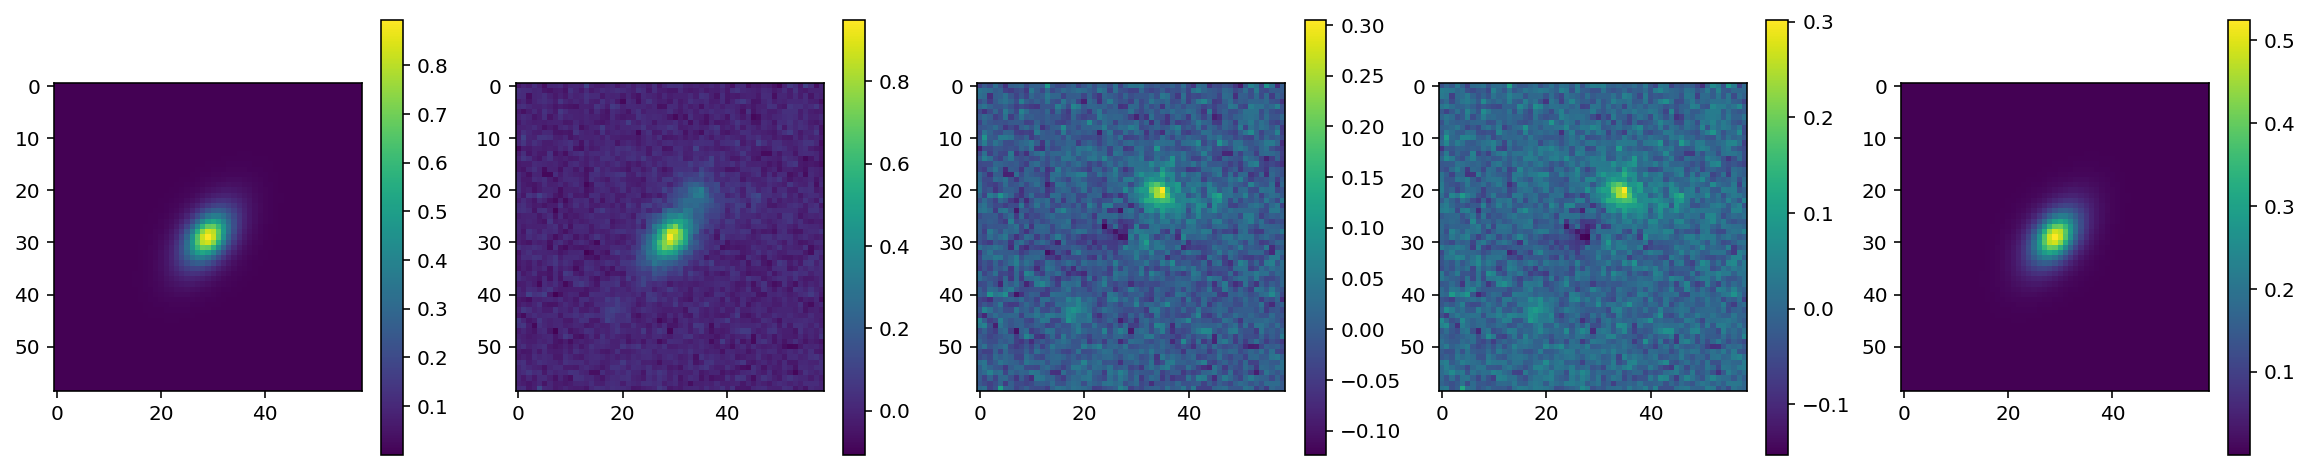

In [57]:
fig, axes = plt.subplots(1,5, figsize =(20,4))

fi1 = axes[0].imshow(image.array.data)
fi2 = axes[1].imshow(gal_img[galaxy_id,:,:,2])
fi3 = axes[2].imshow(gal_img[galaxy_id,:,:,2]-image.array.data)#*np.max(gal_img[galaxy_id,26:32,26:32,2])/np.max(image.array.data))
fi4 = axes[3].imshow(gal_img[galaxy_id,:,:,2]-image_2.array.data*np.max(gal_img[galaxy_id,26:32,26:32,2])/np.max(image_2.array.data))
fi5 = axes[4].imshow(image_2.array.data)

fig.colorbar(fi1, ax=axes[0])
fig.colorbar(fi2, ax=axes[1])
fig.colorbar(fi3, ax=axes[2])
fig.colorbar(fi4, ax=axes[3])
fig.colorbar(fi5, ax=axes[4])

In [1422]:
np.max(gal_img[galaxy_id,26:32,26:32,2])/np.max(image.array.data)

1.0627108272923622

In [1423]:
np.where(gal_img[galaxy_id,:,:,2]==np.max(gal_img[galaxy_id,:,:,2]))

(array([29]), array([29]))

In [1424]:
np.where(img_reduced_shear==np.max(img_reduced_shear))

(array([29]), array([29]))

### Faire mesure d'ellitpicité et reduced shear avec HSM et voir laquelle des deux est la plus proche des valeurs vraies.

In [1425]:
img_reduced_shear = np.zeros((59,59))
img_ellipticity = np.zeros((59,59))

img_reduced_shear = image_2.array.data*np.max(gal_img[galaxy_id,26:32,26:32,2])/np.max(image_2.array.data)
img_ellipticity = image.array.data*np.max(gal_img[galaxy_id,26:32,26:32,2])/np.max(image.array.data)

In [1426]:
np.max(image_2.array.data),np.max(image.array.data), np.max(img_ellipticity), np.max(img_reduced_shear)

(0.52502704, 0.8940246, 0.95008963, 0.95008963)

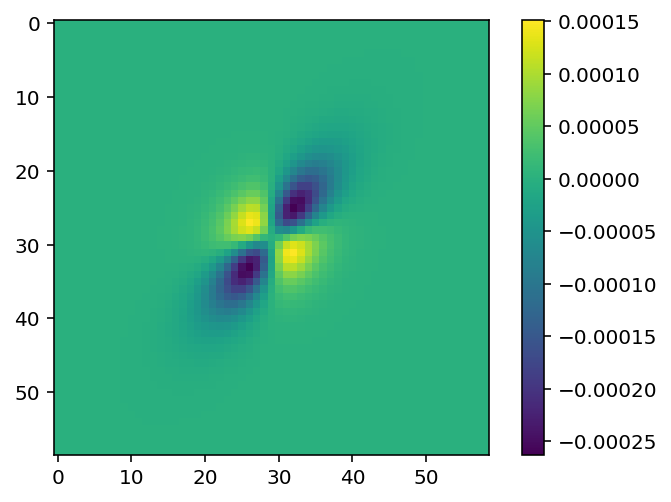

In [1317]:
plt.imshow(img_reduced_shear-img_ellipticity)
plt.colorbar()

In [1259]:
gal_image_out = galsim.Image(img_reduced_shear)
gal_image_out.scale = 0.2

shear_est = 'KSB'
res_out = galsim.hsm.EstimateShear(gal_image_out, psf_i, shear_est=shear_est, strict=True)
print('KSB: '+str([res_out.corrected_g1, res_out.corrected_g2]))

shear_est = 'REGAUSS'
res_out = galsim.hsm.EstimateShear(gal_image_out, psf_i, shear_est=shear_est, strict=True)
print('REGAUSS: '+str([res_out.corrected_e1, res_out.corrected_e2]))

shear_est = 'LINEAR'
res_out = galsim.hsm.EstimateShear(gal_image_out, psf_i, shear_est=shear_est, strict=True)
print('LINEAR: '+str([res_out.corrected_e1, res_out.corrected_e2]))

shear_est = 'BJ'
res_out = galsim.hsm.EstimateShear(gal_image_out, psf_i, shear_est=shear_est, strict=True)
print('BJ: '+str([res_out.corrected_e1, res_out.corrected_e2]))

KSB: [-0.018651332706212997, 0.0436469241976738]
REGAUSS: [-0.042602598667144775, 0.09759067744016647]
LINEAR: [-0.014036624692380428, 0.04148650914430618]
BJ: [-0.031603939831256866, 0.07582530379295349]


In [520]:
gal_image_out = galsim.Image(img_ellipticity)
gal_image_out.scale = 0.2

shear_est = 'KSB'
res_out = galsim.hsm.EstimateShear(gal_image_out, psf_i, shear_est=shear_est, strict=True)
print('KSB: '+str([res_out.corrected_g1, res_out.corrected_g2]))

shear_est = 'REGAUSS'
res_out = galsim.hsm.EstimateShear(gal_image_out, psf_i, shear_est=shear_est, strict=True)
print('REGAUSS: '+str([res_out.corrected_e1, res_out.corrected_e2]))

shear_est = 'LINEAR'
res_out = galsim.hsm.EstimateShear(gal_image_out, psf_i, shear_est=shear_est, strict=True)
print('LINEAR: '+str([res_out.corrected_e1, res_out.corrected_e2]))

shear_est = 'BJ'
res_out = galsim.hsm.EstimateShear(gal_image_out, psf_i, shear_est=shear_est, strict=True)
print('BJ: '+str([res_out.corrected_e1, res_out.corrected_e2]))

KSB: [-0.26502788066864014, -0.9532274603843689]
REGAUSS: [-0.2909577190876007, -1.0309200286865234]
LINEAR: [-0.37928247451782227, -1.3273707628250122]
BJ: [-0.2566581964492798, -0.909518837928772]


True ellipticity:

In [496]:
ell_1 = np.array(test_data['e1'][galaxy_id])
ell_2 = np.array(test_data['e2'][galaxy_id])
shear_1 = np.array(test_data['shear_1'][galaxy_id])
shear_2 = np.array(test_data['shear_2'][galaxy_id])
convergence = np.array(test_data['convergence'][galaxy_id])

ellipticity = calc_lensed_ellipticity(-ell_1, ell_2, shear_1, shear_2, convergence)
ellipticity_conversion = lambda e: 2*e / (1.0+ellipticity*ellipticity)

ellipticity_hsm = ellipticity_conversion(ellipticity)

e_1 = (ellipticity_hsm/ellipticity)*calc_lensed_ellipticity_1(-ell_1, ell_2, shear_1, shear_2, convergence)
e_2 = (ellipticity_hsm/ellipticity)*calc_lensed_ellipticity_2(-ell_1, ell_2, shear_1, shear_2, convergence)

print('Ellipticity: '+str(e_1)+','+str(e_2)+' reduced shear: '+str(calc_lensed_ellipticity_1(-ell_1, ell_2, shear_1, shear_2, convergence))+','+str(calc_lensed_ellipticity_2(-ell_1, ell_2, shear_1, shear_2, convergence)))

Ellipticity: -0.18072651633781117,-0.6539580728323495 reduced shear: -0.10418754052956997,-0.37700213891416107


## Plot img with DM

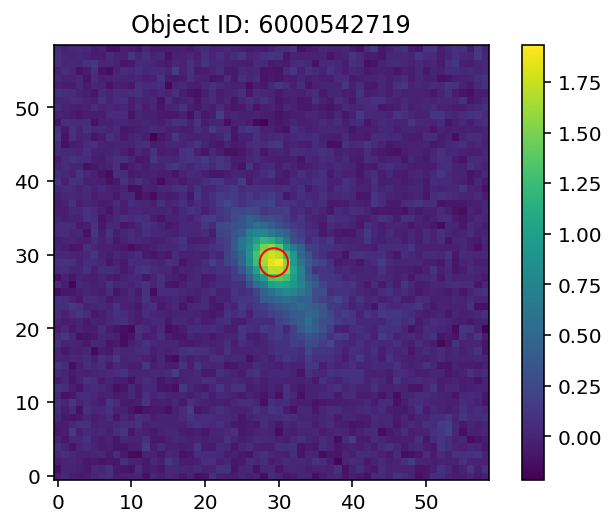

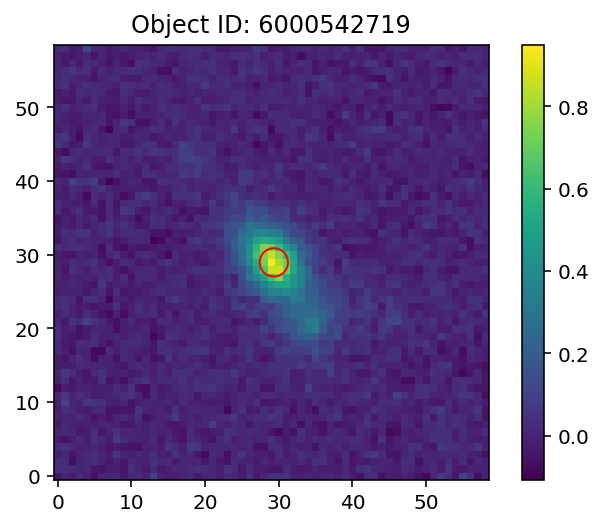

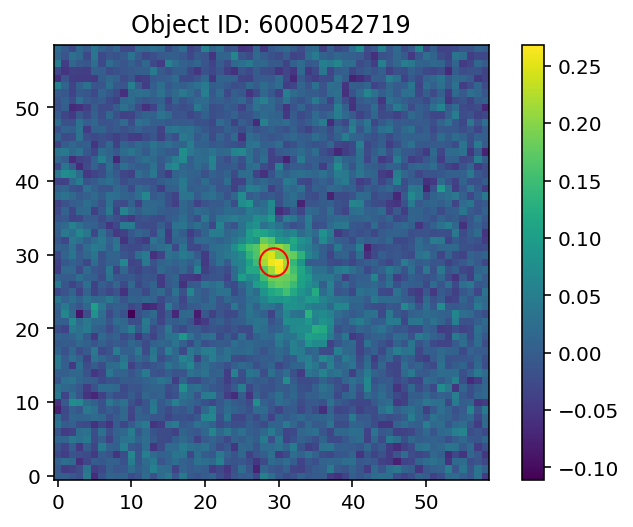

In [214]:
id_ra_dec = Table.from_pandas(pd.DataFrame.from_dict(object_data))

first = id_ra_dec[object_idx[idx]]
ra, dec = first['ra'], first['dec']

cutouts=[cutout_img_dc2.make_cutout_image(butler, ra, dec, filter=band, label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[idx]]) for band in "irg"]
img = rgb.makeRGB(*cutouts)

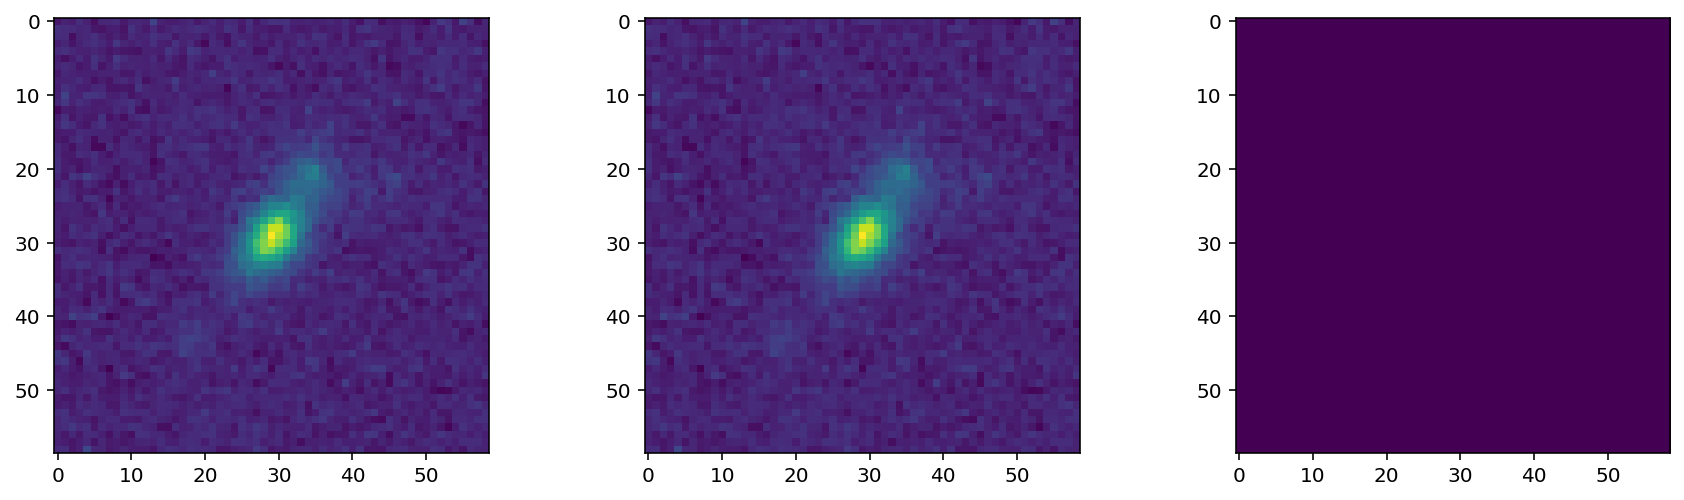

In [203]:
fig, axes = plt.subplots(1,3, figsize = (15,4))
axes[0].imshow(cutouts[1].image.array)
axes[1].imshow(gal_img[galaxy_id,:,:,2])
axes[2].imshow(cutouts[1].image.array-gal_img[galaxy_id,:,:,2])

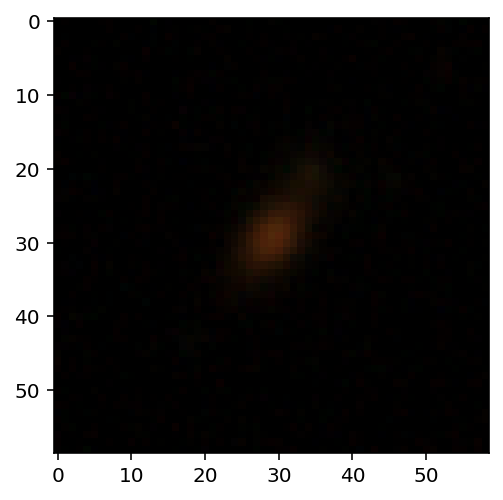

In [196]:
plt.imshow(img)